# Project price cars prediction
*KUBIK Aleksander - KOBANA Johan - JOUYIT Matthieu - DIA4*

Our problem : We want to be able to predict the price of a used car on the market, thanks to its different caracteristics (A DEVELOPPER selon plan.txt)

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
#from catboost import CatBoostRegressor #POUR ALEK !!
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
import time 


XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/Joko/Library/Python/3.9/lib/python/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <FBD6AEF9-AFAB-39D7-B881-755157DA0497> /Users/Joko/Library/Python/3.9/lib/python/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS@rpath/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/opt/libomp/lib/libomp.dylib' (no such file)"]


In [ ]:
cars = pd.read_csv('data.csv')
cars = cars.iloc[:, 1:]
cars.shape

(251079, 14)

In [ ]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251079 entries, 0 to 251078
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   brand                     251079 non-null  object 
 1   model                     251079 non-null  object 
 2   color                     250913 non-null  object 
 3   registration_date         251075 non-null  object 
 4   year                      251079 non-null  object 
 5   price_in_euro             251079 non-null  object 
 6   power_kw                  250945 non-null  object 
 7   power_ps                  250950 non-null  object 
 8   transmission_type         251079 non-null  object 
 9   fuel_type                 251079 non-null  object 
 10  fuel_consumption_l_100km  224206 non-null  object 
 11  fuel_consumption_g_km     251079 non-null  object 
 12  mileage_in_km             250927 non-null  float64
 13  offer_description         251078 non-null  o

In [ ]:
#setting columns into numeric
cars['price_in_euro'] = pd.to_numeric(cars['price_in_euro'], errors='coerce')
cars['power_kw'] = pd.to_numeric(cars['power_kw'], errors='coerce')
cars['power_ps'] = pd.to_numeric(cars['power_ps'], errors='coerce')

In [ ]:
cars['registration_date']

0         10/1995
1         02/1995
2         02/1995
3         07/1995
4         11/1996
           ...   
251074    04/2023
251075    03/2023
251076    05/2023
251077    05/2023
251078    03/2023
Name: registration_date, Length: 251079, dtype: object

In [ ]:
#cleaning and setting datetime for registration_date and year
cars = cars[cars['registration_date'].str.match(r'^(0[1-9]|1[0-2])/[0-9]{4}$', na=False)]
cars['registration_date'] = pd.to_datetime(cars['registration_date'], format='%m/%Y')
cars['registration_date'].value_counts()

cars['year'] = pd.to_datetime(cars['year'], format='%Y')

In [ ]:
#drop missing values
cars = cars.dropna(subset=['color'])

cars = cars.dropna(subset=['power_kw']) #delete also for power_ps because they have the same missing values

cars = cars.dropna(subset=['fuel_consumption_l_100km'])

cars = cars.dropna(subset=['mileage_in_km'])

cars = cars.drop(columns='offer_description')

In [ ]:
cars.isna().sum()

brand                       0
model                       0
color                       0
registration_date           0
year                        0
price_in_euro               0
power_kw                    0
power_ps                    0
transmission_type           0
fuel_type                   0
fuel_consumption_l_100km    0
fuel_consumption_g_km       0
mileage_in_km               0
dtype: int64

In [ ]:
cars['transmission_type'].value_counts()

transmission_type
Automatic         114123
Manual            108557
Unknown              770
Semi-automatic       283
Name: count, dtype: int64

In [ ]:
cars['fuel_type'].value_counts() 

fuel_type
Petrol           132026
Diesel            78928
Hybrid            10312
LPG                1054
Electric            471
CNG                 414
Diesel Hybrid       375
Other                87
Hydrogen             38
Unknown              23
Ethanol               5
Name: count, dtype: int64

In [ ]:
cars = cars[cars['transmission_type'] != 'Unknown']
valid_fuels = ['Petrol','Diesel','Hybrid','LPG','Electric']
cars = cars[cars['fuel_type'].isin(valid_fuels)]

In [ ]:
#cleaning and setting float for fuel_consumption_l_100km
cars = cars[cars['fuel_consumption_l_100km'].str.contains('l/100 km', na=False)]

cars['fuel_consumption_l_100km'] = cars['fuel_consumption_l_100km'].str.extract(r'([\d,]+)')
cars['fuel_consumption_l_100km'] = cars['fuel_consumption_l_100km'].astype(str).str.replace(',', '.', regex=False)

cars['fuel_consumption_l_100km'] = pd.to_numeric(cars['fuel_consumption_l_100km'], errors='coerce')

In [ ]:
#cleaning and setting float for fuel_consumption_g_km
cars = cars[cars['fuel_consumption_g_km'].str.contains('g/km', na=False)] 
cars['fuel_consumption_g_km'] = cars['fuel_consumption_g_km'].astype(str).str.replace(',', '.', regex=False)

cars['fuel_consumption_g_km'] = cars['fuel_consumption_g_km'].str.extract(r'([\d,]+)')

cars['fuel_consumption_g_km'] = pd.to_numeric(cars['fuel_consumption_g_km'], errors='coerce')
cars['fuel_consumption_g_km'] = cars['fuel_consumption_g_km'].replace(0, np.nan)

cars = cars.dropna(subset=['fuel_consumption_g_km'])

In [ ]:
#shape and info after cleaning
print(cars.shape)
print(cars.info())

(197274, 13)
<class 'pandas.core.frame.DataFrame'>
Index: 197274 entries, 0 to 251076
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   brand                     197274 non-null  object        
 1   model                     197274 non-null  object        
 2   color                     197274 non-null  object        
 3   registration_date         197274 non-null  datetime64[ns]
 4   year                      197274 non-null  datetime64[ns]
 5   price_in_euro             197274 non-null  float64       
 6   power_kw                  197274 non-null  float64       
 7   power_ps                  197274 non-null  float64       
 8   transmission_type         197274 non-null  object        
 9   fuel_type                 197274 non-null  object        
 10  fuel_consumption_l_100km  197274 non-null  float64       
 11  fuel_consumption_g_km     197274 non-null  float64       

In [ ]:
cars.describe()

,registration_date,year,price_in_euro,power_kw,power_ps,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km
count,197274,197274,1.972740e+05,197274.000000,197274.000000,197274.000000,197274.000000,1.972740e+05
mean,2017-01-09 16:19:32.444417536,2016-08-04 02:15:24.334681856,2.603004e+04,124.247037,169.011157,6.146566,146.134133,8.183402e+04
min,1995-01-01 00:00:00,1995-01-01 00:00:00,1.490000e+02,10.000000,14.000000,0.000000,1.000000,0.000000e+00
25%,2014-05-01 00:00:00,2014-01-01 00:00:00,1.249000e+04,81.000000,110.000000,4.900000,119.000000,2.315125e+04
50%,2018-05-01 00:00:00,2018-01-01 00:00:00,1.998000e+04,110.000000,150.000000,5.700000,137.000000,6.500000e+04
75%,2020-11-01 00:00:00,2020-01-01 00:00:00,2.992350e+04,140.000000,190.000000,6.700000,164.000000,1.211248e+05
max,2023-07-01 00:00:00,2023-01-01 00:00:00,5.890500e+06,735.000000,999.000000,173.000000,999.000000,3.800000e+06
std,NaN,NaN,3.592503e+04,69.665203,94.690991,3.935359,46.203906,7.608103e+04


In [ ]:
cars.isnull().sum()

brand                       0
model                       0
color                       0
registration_date           0
year                        0
price_in_euro               0
power_kw                    0
power_ps                    0
transmission_type           0
fuel_type                   0
fuel_consumption_l_100km    0
fuel_consumption_g_km       0
mileage_in_km               0
dtype: int64

In [ ]:
cars.duplicated().sum()

np.int64(6506)

In [ ]:
doublons = cars[cars.duplicated(keep=False)]
print(doublons)

             brand               model  color registration_date       year  \
173     alfa-romeo      Alfa Romeo 159   grey        2006-09-01 2006-01-01   
174     alfa-romeo      Alfa Romeo 159   grey        2006-09-01 2006-01-01   
562     alfa-romeo   Alfa Romeo Giulia  black        2016-10-01 2016-01-01   
566     alfa-romeo   Alfa Romeo Giulia  black        2016-10-01 2016-01-01   
956     alfa-romeo  Alfa Romeo Stelvio    red        2021-12-01 2021-01-01   
...            ...                 ...    ...               ...        ...   
251038       volvo           Volvo V60  black        2023-05-01 2023-01-01   
251039       volvo           Volvo V60  black        2023-05-01 2023-01-01   
251040       volvo           Volvo V60  black        2023-05-01 2023-01-01   
251051       volvo           Volvo V60  black        2023-05-01 2023-01-01   
251053       volvo           Volvo V60  black        2023-05-01 2023-01-01   

        price_in_euro  power_kw  power_ps transmission_type fue

In [ ]:
cars = cars.drop_duplicates()

<Axes: >

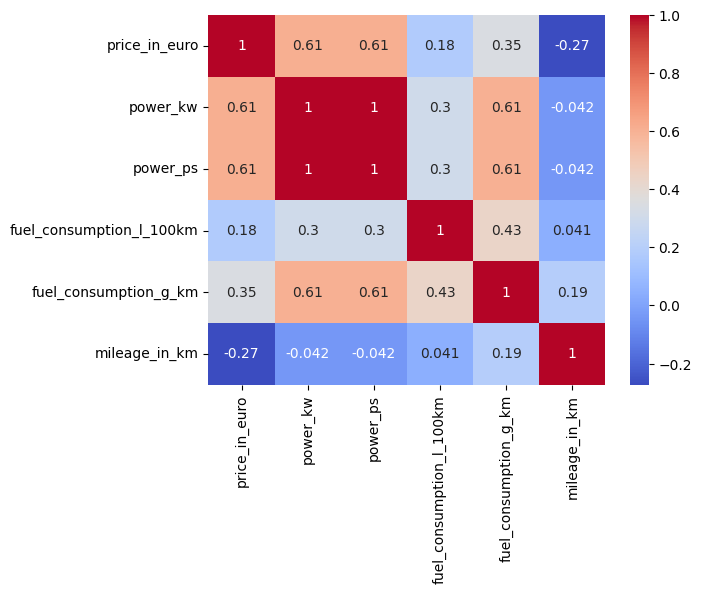

In [ ]:
sns.heatmap(cars.corr(numeric_only=True), annot=True, cmap='coolwarm')

#### Correlation Heatmap — Key Insights

Perfect correlation (1.00) between power_kW and power_ps.
-> They are redundant features, we wiil keep only one.

Strong correlation with power (0.61)
-> More powerful cars tend to be more expensive.

Negative correlation with mileage (-0.27)
-> Higher mileage cars tend to have lower prices.

Weak correlation with fuel consumption (0.18–0.35)
-> Secondary effect on price.

The mileage variable has very weak correlation with all other variables
-> Independent and informative for pricing models.

In [ ]:
#drop of power_ps because it represents the same as power_kw like shown on the heatmap
cars.drop('power_ps', axis=1,inplace=True)

In [ ]:
cars.reset_index(drop=True,inplace=True)
cars.head(10)

,brand,model,color,registration_date,year,price_in_euro,power_kw,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km
0,alfa-romeo,Alfa Romeo GTV,red,1995-10-01,1995-01-01,1300.0,148.0,Manual,Petrol,10.9,260.0,160500.0
1,alfa-romeo,Alfa Romeo Spider,black,1995-07-01,1995-01-01,4900.0,110.0,Manual,Petrol,9.5,225.0,189500.0
2,alfa-romeo,Alfa Romeo Spider,red,1996-04-01,1996-01-01,7900.0,110.0,Manual,Petrol,9.5,225.0,47307.0
3,alfa-romeo,Alfa Romeo 145,red,1996-12-01,1996-01-01,3500.0,110.0,Manual,Petrol,8.8,210.0,230000.0
4,alfa-romeo,Alfa Romeo 164,black,1996-07-01,1996-01-01,5500.0,132.0,Manual,Petrol,13.4,320.0,168000.0
5,alfa-romeo,Alfa Romeo Spider,black,1996-07-01,1996-01-01,8990.0,141.0,Manual,Petrol,11.0,265.0,168600.0
6,alfa-romeo,Alfa Romeo Spider,black,1996-01-01,1996-01-01,6976.0,110.0,Manual,Petrol,9.2,220.0,99000.0
7,alfa-romeo,Alfa Romeo Spider,silver,1996-02-01,1996-01-01,5499.0,141.0,Manual,Petrol,11.1,265.0,157000.0
8,alfa-romeo,Alfa Romeo Spider,silver,1996-10-01,1996-01-01,8499.0,110.0,Manual,Petrol,9.5,225.0,15550.0
9,alfa-romeo,Alfa Romeo GTV,grey,1997-05-01,1997-01-01,15800.0,162.0,Manual,Petrol,11.7,125.0,177000.0


array([[<Axes: title={'center': 'registration_date'}>,
        <Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'price_in_euro'}>],
       [<Axes: title={'center': 'power_kw'}>,
        <Axes: title={'center': 'fuel_consumption_l_100km'}>,
        <Axes: title={'center': 'fuel_consumption_g_km'}>],
       [<Axes: title={'center': 'mileage_in_km'}>, <Axes: >, <Axes: >]],
      dtype=object)

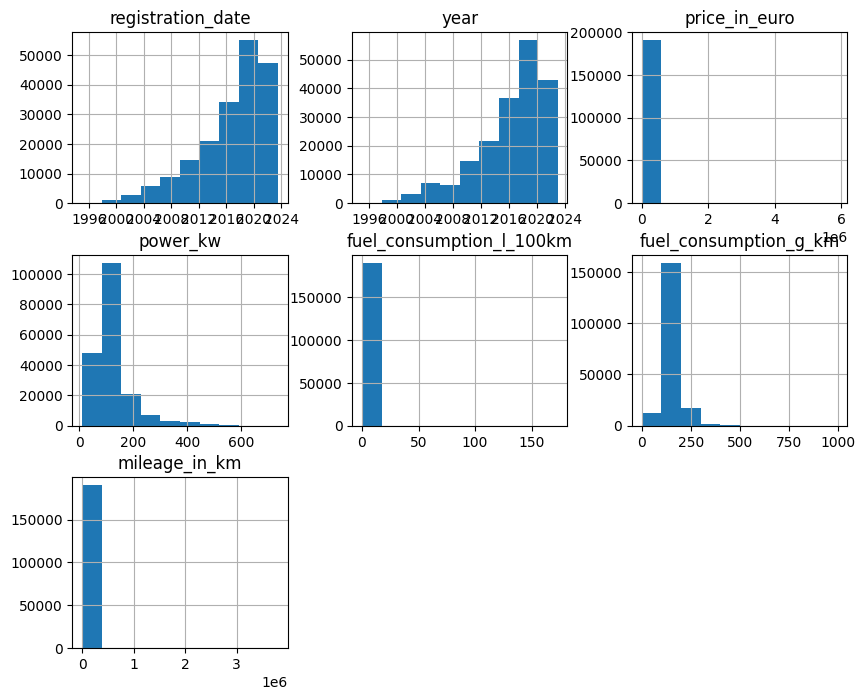

In [ ]:
cars.hist(figsize=(10,8))

<Axes: xlabel='year'>

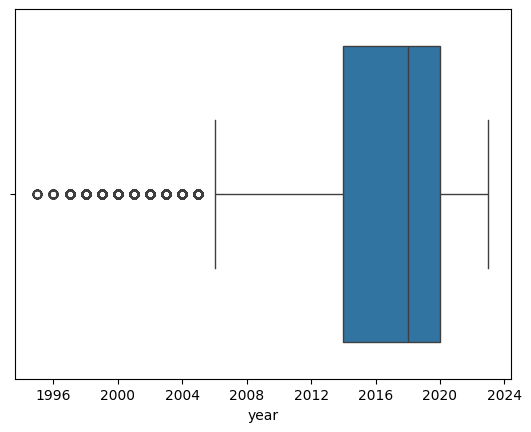

In [ ]:
sns.boxplot(data=cars, x='year')

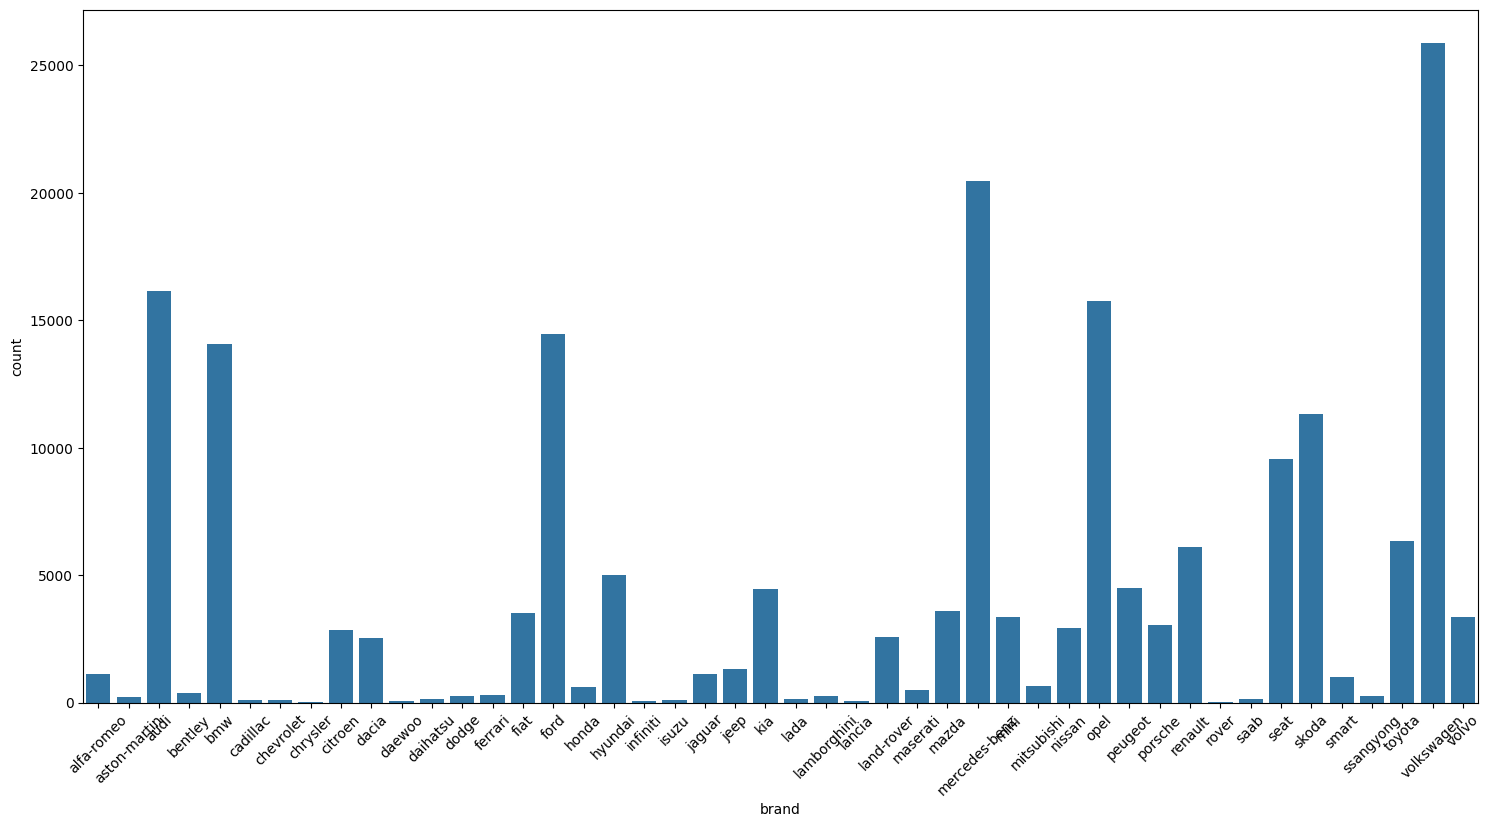

In [ ]:
#noumber of cars per brand
plt.figure(figsize=(18,9))  
sns.countplot(data=cars, x='brand')
plt.xticks(rotation=45)
plt.show()

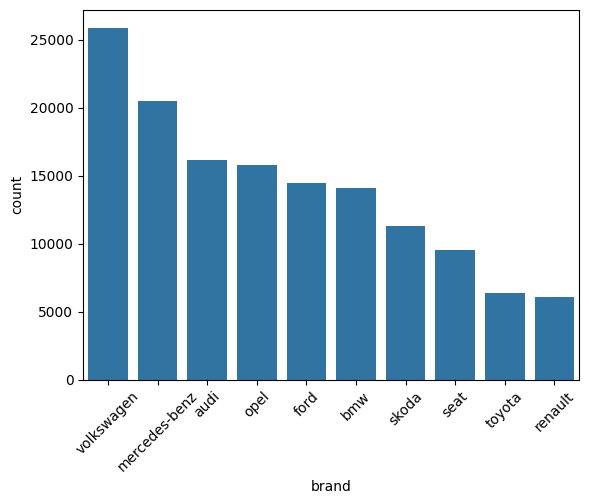

In [ ]:
#top 10 most present brands
top_brands = cars['brand'].value_counts().nlargest(10).index
sns.countplot(data=cars[cars['brand'].isin(top_brands)], x='brand', order=top_brands)
plt.xticks(rotation=45)
plt.show()

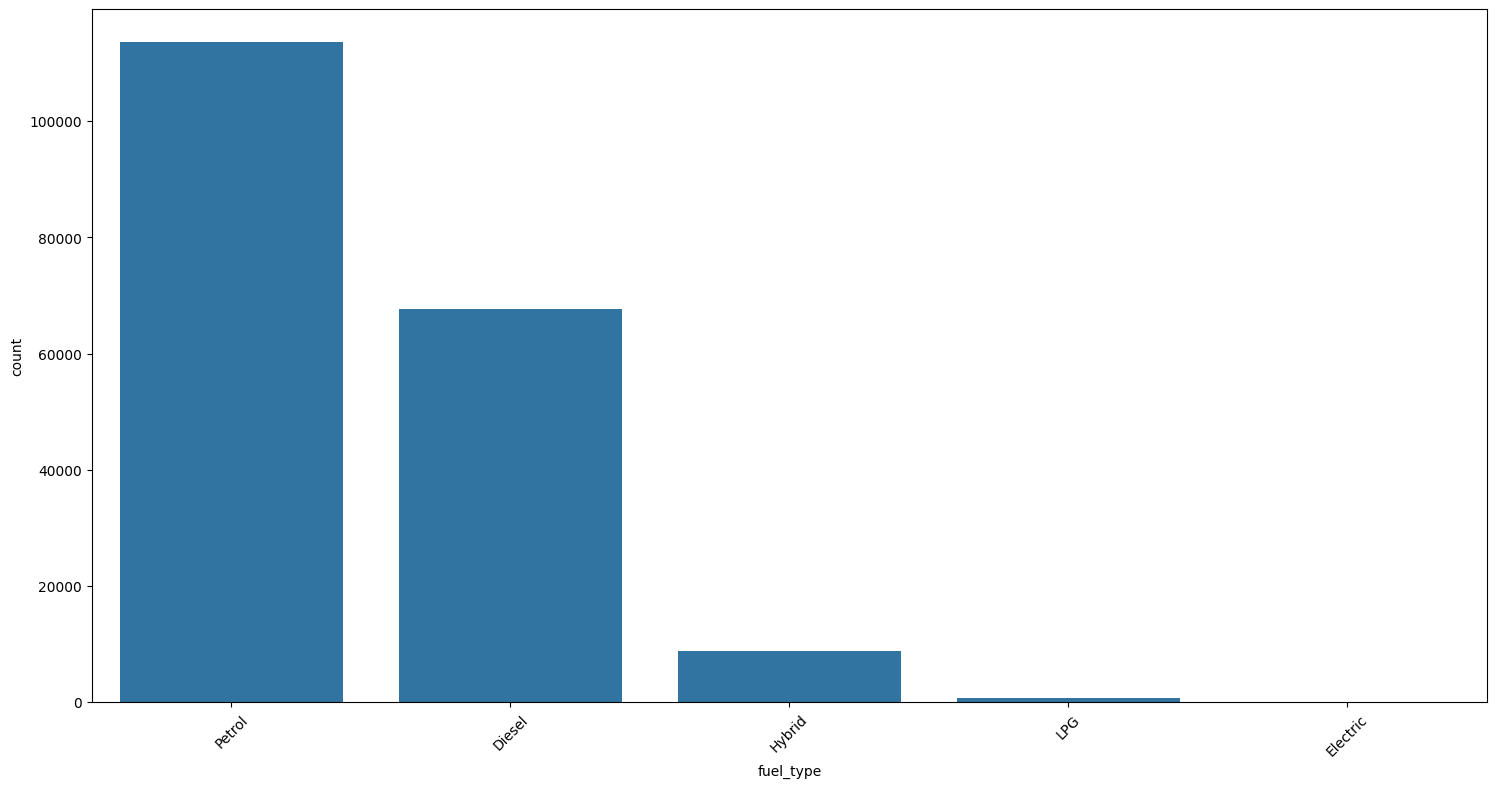

In [ ]:
plt.figure(figsize=(18,9))  
sns.countplot(data=cars, x='fuel_type')
plt.xticks(rotation=45)
plt.show()

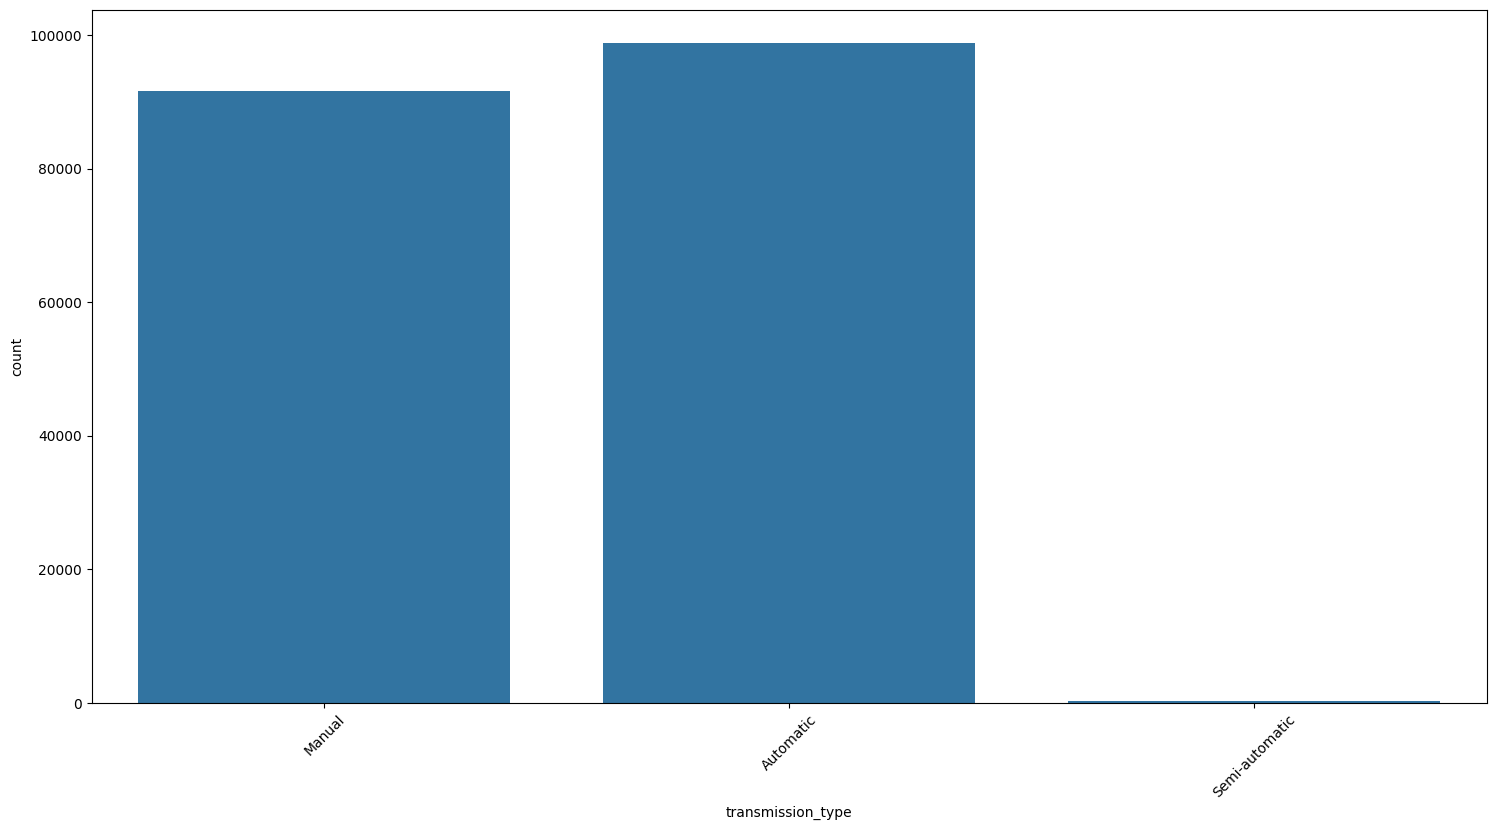

In [ ]:
plt.figure(figsize=(18,9))  
sns.countplot(data=cars, x='transmission_type')
plt.xticks(rotation=45)
plt.show()

In [ ]:
#outlier for price
cars.drop(cars['price_in_euro'].idxmax(),inplace=True)

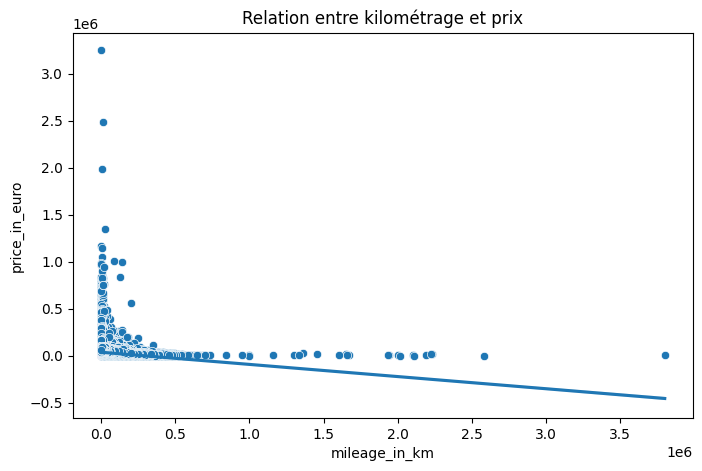

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=cars, x='mileage_in_km', y='price_in_euro')
sns.regplot(data=cars, x='mileage_in_km', y='price_in_euro', scatter=False)
plt.title('Relation entre kilométrage et prix')
plt.show()


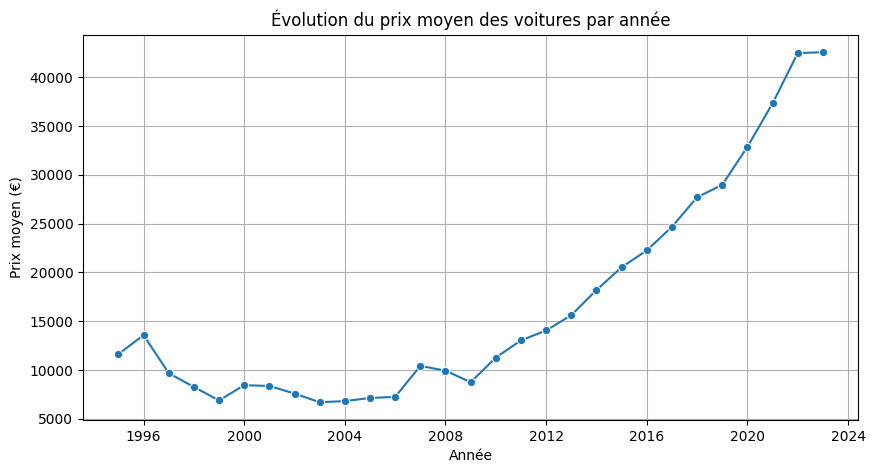

In [ ]:
price_by_year = cars.groupby('year')['price_in_euro'].mean().reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(data=price_by_year, x='year', y='price_in_euro', marker='o')
plt.title("Évolution du prix moyen des voitures par année")
plt.xlabel("Année")
plt.ylabel("Prix moyen (€)")
plt.grid(True)
plt.show()

In [ ]:
#feature engineering
cars['age'] = 2025 - cars['year'].dt.year
cars['registration_year'] = cars['registration_date'].dt.year
cars = cars.drop(columns=['year', 'registration_date'])

#ici nous utilisons np.where pour éviter la division par zéro!
cars['power_efficiency'] = np.where(
    cars['fuel_consumption_l_100km'] > 0,
    cars['power_kw'] / cars['fuel_consumption_l_100km'],
    np.nan
)
cars["price_per_km"] = np.where(
    cars["mileage_in_km"] > 0,
    cars["price_in_euro"] / cars["mileage_in_km"],
    np.nan
) 

In [ ]:
cars.isna().sum()

brand                         0
model                         0
color                         0
price_in_euro                 0
power_kw                      0
transmission_type             0
fuel_type                     0
fuel_consumption_l_100km      0
fuel_consumption_g_km         0
mileage_in_km                 0
age                           0
registration_year             0
power_efficiency              5
price_per_km                151
dtype: int64

In [ ]:
cars.dropna(subset=['power_efficiency'],inplace=True)
cars.dropna(subset=['price_per_km'], inplace=True)

In [ ]:
cars.isna().sum()

brand                       0
model                       0
color                       0
price_in_euro               0
power_kw                    0
transmission_type           0
fuel_type                   0
fuel_consumption_l_100km    0
fuel_consumption_g_km       0
mileage_in_km               0
age                         0
registration_year           0
power_efficiency            0
price_per_km                0
dtype: int64

In [ ]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 190611 entries, 0 to 190767
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   brand                     190611 non-null  object 
 1   model                     190611 non-null  object 
 2   color                     190611 non-null  object 
 3   price_in_euro             190611 non-null  float64
 4   power_kw                  190611 non-null  float64
 5   transmission_type         190611 non-null  object 
 6   fuel_type                 190611 non-null  object 
 7   fuel_consumption_l_100km  190611 non-null  float64
 8   fuel_consumption_g_km     190611 non-null  float64
 9   mileage_in_km             190611 non-null  float64
 10  age                       190611 non-null  int32  
 11  registration_year         190611 non-null  int32  
 12  power_efficiency          190611 non-null  float64
 13  price_per_km              190611 non-null  float6

In [ ]:
#test without outliers (top 0.5%)
cars = cars[cars['price_in_euro'] < cars['price_in_euro'].quantile(0.995)]

In [ ]:
# ---------------------------
# 1) Columns concerned
# ---------------------------
target = "price_in_euro"

target_encoding_cols = ["brand", "model"] #because too many different values
one_hot_cols = ["color", "transmission_type", "fuel_type"]

# ---------------------------
# 2) Preprocessors
# ---------------------------

# Target Encoding  (mean of the price per category)
target_encoder = TargetEncoder(cols=target_encoding_cols)

# One-Hot Encoding
onehot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

# ---------------------------
# 3) ColumnTransformer
# ---------------------------

preprocessor = ColumnTransformer(
    transformers=[
        ("target_enc", target_encoder, target_encoding_cols),
        ("onehot", onehot_encoder, one_hot_cols)
    ],
    remainder="passthrough"  # keep numericals columns like that
)

X = cars.drop(columns=[target])
y = cars[target]

## Model Selection: Dummy, Linear Regression, and Random Forest

In order to evaluate different approaches and understand the complexity of the car price prediction task, we compare three types of models, ranging from very simple to more advanced


- **DummyRegressor**: This **baseline model** simply predicts the median value of the target variable. It is useful for benchmarking, as it allows us to compare our advanced models against a simple reference. However, it does not capture any relationships in the data and should not be used for real predictions. If a more complex model does not significantly outperform the DummyRegressor, it means that our preprocessing or feature engineering must be improved.


- **Linear Regression**: This model predicts the target as a linear combination of the input features. It is easy to interpret and fast to train, but it assumes a linear relationship between features and target, which may not always be true. It can struggle with complex, non-linear patterns. For instance, it cannot capture interactions such as “newer cars lose value slower depending on the brand”.


- **Random Forest Regressor**: This ensemble model combines multiple decision trees to improve prediction accuracy and handle non-linear relationships. It is robust to outliers and can model complex interactions, but it is less interpretable and can be slower to train, especially on large datasets. It also provides feature importance scores, which help interpret which attributes influence the price the most.


Using these three models allows us to compare simple, interpretable approaches with more complex, powerful ones, and to select the best model for our car price prediction task.

In [ ]:
models = {
    "dummy": DummyRegressor(strategy="median"), # Baseline model that predicts the median value of the target.

    "lin_reg": LinearRegression(), # Standard linear regression model for predicting continuous values.
    
    "rf": RandomForestRegressor(random_state=42) # Ensemble model using multiple decision trees for regression.
}

pipelines = {
    name: Pipeline(steps=[
        ("preprocessing", preprocessor),
        ("regressor", model)
    ])
    for name, model in models.items()
}

## Train/Test Split

Before training our models, we split the dataset into training and test sets using train_test_split.
This is a crucial step to ensure that model evaluation is fair and unbiased.

The preprocessing pipeline is fitted only on the training data, where it learns:
* target encoding mappings,
* one-hot encoding categories,
* numerical transformations,
and any other preprocessing steps.

The same fitted transformations are then applied to the test set, ensuring that the model never has access to information from the test data during training. This prevents **data leakage**, which would artificially inflate evaluation metrics and make the model appear more accurate than it truly is.

Once preprocessing is correctly handled inside the pipeline, each model (DummyRegressor, Linear Regression, Random Forest) is trained on the transformed training data and evaluated on the transformed test data. The comparison of these models allows us to measure the added value of increasingly complex algorithms over a simple baseline.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}")


dummy - MAE: 12759.56, RMSE: 21718.47, R2: -0.05
lin_reg - MAE: 5479.54, RMSE: 9851.82, R2: 0.78
rf - MAE: 751.46, RMSE: 3115.29, R2: 0.98


#### 1. Dummy Regressor (Baseline)

The DummyRegressor serves as a baseline model by always predicting the median car price.
It does not learn any relationship from the data and is only used as a reference point.

**Results:**
* MAE: ~12 759 €
* RMSE: ~21 718 €
* R²: -0.05

**Interpretation:**

The negative R² confirms that the model performs worse than predicting the mean price.
This is normal and expected: the Dummy model does not use any features and cannot capture any structure in the data.
It is useful because it provides a minimum benchmark that all real models should outperform.

#### 2. Linear Regression

Linear Regression models the target as a linear combination of the input features.
It is fast, simple, and interpretable, but limited to linear relationships.

**Results:**

* MAE: ~5 479 €
* RMSE: ~9 851 €
* R²: 0.78

**Interpretation:**

The MAE is more than twice as good as the DummyRegressor.
An R² of 0.78 means the model explains 78% of the variance in car prices.
This shows that the preprocessing pipeline is effective and that the dataset contains strong linear trends.
However, since car prices depend on non-linear interactions (brand × year, mileage × power, etc.), Linear Regression remains limited.

#### 3. Random Forest Regressor

Random Forest is an ensemble method that combines multiple decision trees to capture non-linear patterns and feature interactions.

**Results:**

* MAE: ~751 €
* RMSE: ~3 115 €
* R²: 0.98

**Interpretation:**

Huge improvement over Linear Regression: MAE drops below 1,000 €, which is excellent for used car pricing.
R² = 0.98, meaning the Random Forest explains 98% of the variance.

The model successfully captures non-linear relationships, interactions between features and brand-specific pricing effects.

This makes it the best-performing model so far and a strong candidate for the final model.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Function to print scores
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n===== {name} =====")
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"R²   : {r2:.4f}")

# ====================================
# 1) XGBoost Regressor
# ====================================

xgb_model = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", XGBRegressor(
    ))
])

xgb_model.fit(X_train, y_train)
evaluate_model("XGBoost", xgb_model, X_test, y_test)


# ====================================
# 2) CatBoost Regressor (gère automatiquement les catégorielles)
# ====================================

#cat_model = Pipeline(steps=[
#    ("preprocessing", preprocessor),
#    ("model", CatBoostRegressor(
#    ))
#])
#
#cat_model.fit(X_train, y_train)
#evaluate_model("CatBoost", cat_model, X_test, y_test)



===== XGBoost =====
MAE  : 1191.23
RMSE : 2594.54
R²   : 0.9851


XGBoost demonstrates much stronger performance overall. Although its MAE is slightly higher (1191 €), the RMSE drops to 2594 €, meaning the model makes far fewer large prediction errors. Its R² score of 0.98 shows that it explains 98% of the variance in car prices, which is excellent for a real-world dataset.

Conclusion

XGBoost is a very good model like Random Forest. So we need to compare the results with tuning hyperparameters now.

In [ ]:
# ============================
# Hyperparameter Tuning for XGBoost
# ============================

# ------------------------------------------
# 1) Search parameters
# ------------------------------------------

param_distributions = {
    "model__n_estimators": [200, 300, 500, 800, 1000],
    "model__learning_rate": [0.01, 0.03, 0.05, 0.1],
    "model__max_depth": [4, 6, 8, 10],
    "model__subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "model__gamma": [0, 1, 5, 10],
    "model__min_child_weight": [1, 3, 5, 7]
}

# ------------------------------------------
# 2) Pipeline
# ------------------------------------------

xgb_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", XGBRegressor(
        objective="reg:squarederror",
        tree_method="hist"
    ))
])

# ------------------------------------------
# 3) Randomized Search
# ------------------------------------------

random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_distributions,
    n_iter=25,               # number of combinations to test
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# ------------------------------------------
# 4) Fit + timing
# ------------------------------------------

print("Starting XGBoost hyperparameter search...")
start = time.time()

random_search.fit(X_train, y_train)

end = time.time()
print(f"\nSearch completed in {end - start:.1f} seconds")

# ------------------------------------------
# 5) Best results
# ------------------------------------------

print("\nBest MAE score:", -random_search.best_score_)
print("\nBest hyperparameters:")
for param, value in random_search.best_params_.items():
    print(f"{param}: {value}")

# ------------------------------------------
# 6) Best model
# ------------------------------------------

best_xgb_model = random_search.best_estimator_
print("\nBest model ready as 'best_xgb_model'")


Starting XGBoost hyperparameter search...
Fitting 3 folds for each of 25 candidates, totalling 75 fits

Search completed in 189.6 seconds

Best MAE score: 745.2930268384927

Best hyperparameters:
model__subsample: 0.6
model__n_estimators: 500
model__min_child_weight: 1
model__max_depth: 10
model__learning_rate: 0.05
model__gamma: 5
model__colsample_bytree: 1.0

Best model ready as 'best_xgb_model'



===== xgboost =====
MAE  : 678.10
RMSE : 2219.36
R²   : 0.9891


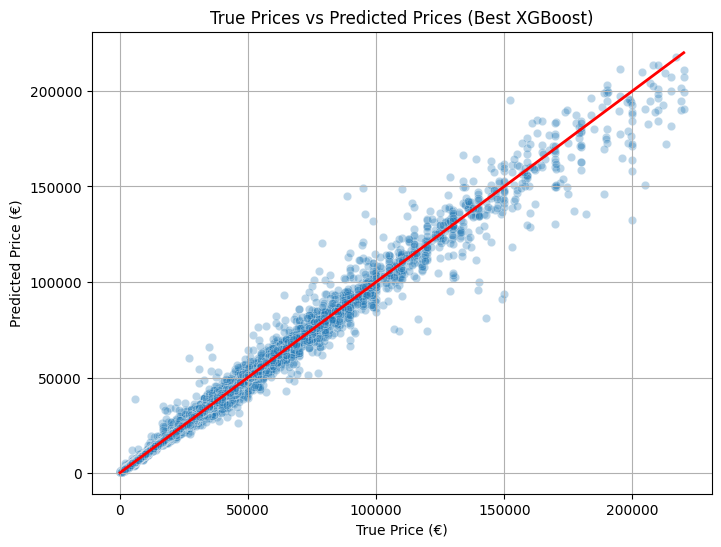

In [ ]:
# ============================
# Best model evaluation
# ============================

evaluate_model('xgboost',best_xgb_model, X_test,y_test)

# ---------------------------
# Plot: True vs Predicted
# ---------------------------

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=best_xgb_model.predict(X_test), alpha=0.3)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linewidth=2)

plt.title("True Prices vs Predicted Prices (Best XGBoost)")
plt.xlabel("True Price (€)")
plt.ylabel("Predicted Price (€)")
plt.grid(True)
plt.show()


The scatter plot compares true car prices (x-axis) with model predictions (y-axis).
Each point represents one prediction.
The red diagonal line corresponds to perfect predictions (true = predicted).
The closer the points are to this line, the more accurate the model is.
A well-performing regression model produces a cloud of points tightly aligned around the diagonal.

-------------------------------------------------------------------------------------
### Hyperparameter Tuning for Random Forest

Here, we use RandomizedSearchCV to automatically test different combinations of Random Forest parameters.
The goal is to find the best settings that improve model accuracy and reduce prediction error.
This process helps optimize the model for our car price prediction task.

In [ ]:
######## LE CPU VA TOURNER A FOND LORS DE CETTE ETAPE ########
rf_pipeline = Pipeline(steps=[  # data leakage-safe
    ("preprocessing", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

param_distributions = {         # we define an area of search with various values for the hyperparameters
    "regressor__n_estimators": [100,200],
    "regressor__max_depth": [2,5,10,12,15],
    "regressor__min_samples_split": [2, 5, 10],
    "regressor__min_samples_leaf": [1, 2, 4],
    "regressor__max_features": ["auto", "sqrt", 0.5],
    "regressor__bootstrap": [True, False]
}

search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_distributions,
    n_iter=8,                                     # will try 8 different combinations with the values in param_distributions
    cv=3,                                         # 3-fold cross validation
    scoring="neg_mean_absolute_error",            # we optimize the MAE (bigger the negative MAE equals to a better score)
    n_jobs=-1,                                    # setting CPU usage for the run
    random_state=42
)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("Best MAE:", -search.best_score_)           # -(negative MAE) => MAE


c:\Users\matth\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
3 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\matth\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\matth\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\matth\AppData\

Best params: {'regressor__n_estimators': 200, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 0.5, 'regressor__max_depth': 12, 'regressor__bootstrap': False}
Best MAE: 2012.139411430194


In [ ]:
evaluate_model('rf',search.best_estimator_,X_test,y_test)


===== rf =====
MAE  : 1972.20
RMSE : 4288.61
R²   : 0.9592


Hyperparameter tuning for Random Forest is not good because RF is already a model with a high computational time so testing a lot of combinations of parameters is too long

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# ============================
# 9) Stacking Regressor (meta-model)
# ============================

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# Base models (already trained pipelines)
estimators = [
    ("xgb", best_xgb_model),
    ("rf", pipelines['rf'])
]

# Meta-model (final predictor)
meta_model = LinearRegression()

stacked_model = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model,
    n_jobs=-1,
    passthrough=False
)

print("Training stacking model...")
stacked_model.fit(X_train, y_train)

# Evaluate
evaluate_model('meta-model',stacked_model,X_test,y_test)

In [ ]:
# ============================
# 10) Voting Regressor (XGBoost + RandomForest + LinearRegression)
# ============================

from sklearn.ensemble import VotingRegressor

pipelines["rf"].fit(X_train, y_train)
pipelines["lin_reg"].fit(X_train, y_train)

voting_reg = VotingRegressor(
    estimators=[
        ("xgb", best_xgb_model),    
        ("rf", pipelines["rf"]),     
        ("lin", pipelines["lin_reg"])
    ],
    n_jobs=-1
)

print("Training VotingRegressor...")
voting_reg.fit(X_train, y_train)

# Metrics
evaluate_model('voting',voting_reg,X_test,y_test)

In [ ]:
# ============================
# 11) Blending Regressor 
# ============================

X_train_blend, X_holdout, y_train_blend, y_holdout = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

pipelines["rf"].fit(X_train_blend, y_train_blend)
best_xgb_model.fit(X_train_blend, y_train_blend)
pipelines["lin_reg"].fit(X_train_blend, y_train_blend)

blend_features = np.column_stack([
    best_xgb_model.predict(X_holdout),
    pipelines["rf"].predict(X_holdout),
])

meta_blend = LinearRegression()
meta_blend.fit(blend_features, y_holdout)

X_test_stack = np.column_stack([
    best_xgb_model.predict(X_test),
    pipelines["rf"].predict(X_test),
])

# Metrics
evaluate_model('blending',meta_blend,X_test_stack,y_test)